<a href="https://colab.research.google.com/github/balcomes/keras-autoencoders/blob/master/train_conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")

		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")

		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

In [3]:
# USAGE
# python train_conv_autoencoder.py

# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-s", "--samples", type=int, default=8,
#	help="# number of samples to visualize when decoding")
#ap.add_argument("-o", "--output", type=str, default="output.png",
#	help="path to output visualization file")
#ap.add_argument("-p", "--plot", type=str, default="plot.png",
#	help="path to output plot file")
#args = vars(ap.parse_args())

# initialize the number of epochs to train for and batch size
EPOCHS = 1
BS = 32

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])

# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
outputs = None

# loop over our number of output samples
#for i in range(0, args["samples"]):
	# grab the original image and reconstructed image
#	original = (testX[i] * 255).astype("uint8")
#	recon = (decoded[i] * 255).astype("uint8")

	# stack the original and reconstructed image side-by-side
	#output = np.hstack([original, recon])

	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	#if outputs is None:
	#	outputs = output

	# otherwise, vertically stack the outputs
	#else:
	#	outputs = np.vstack([outputs, output])

# save the outputs image to disk
#cv2.imwrite(args["output"], outputs)

[INFO] loading MNIST dataset...
11493376/11490434 [==============================] - 0s 0us/step
[INFO] building autoencoder...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 191s 3ms/sample - loss: 0.0183 - val_loss: 0.0110
[INFO] making predictions...


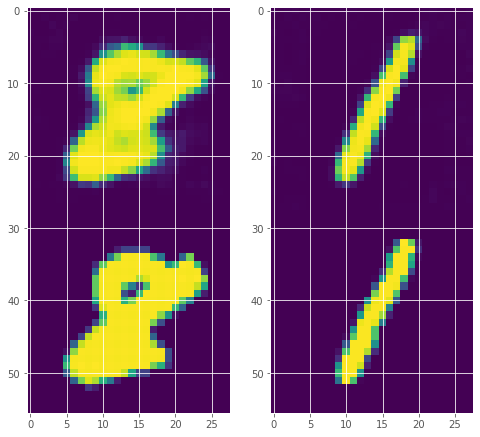

In [4]:
%matplotlib inline
import numpy as np

fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
for i in range(1, columns*rows + 1):
    k = np.random.randint(0,10000)
    img = np.vstack([decoded[k,:,:,0], testX[k,:,:,0]])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

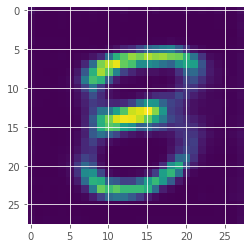

In [5]:
plt.imshow(autoencoder.predict(np.asarray(np.random.random(28*28).reshape([1,28,28,1])))[0,:,:,0])

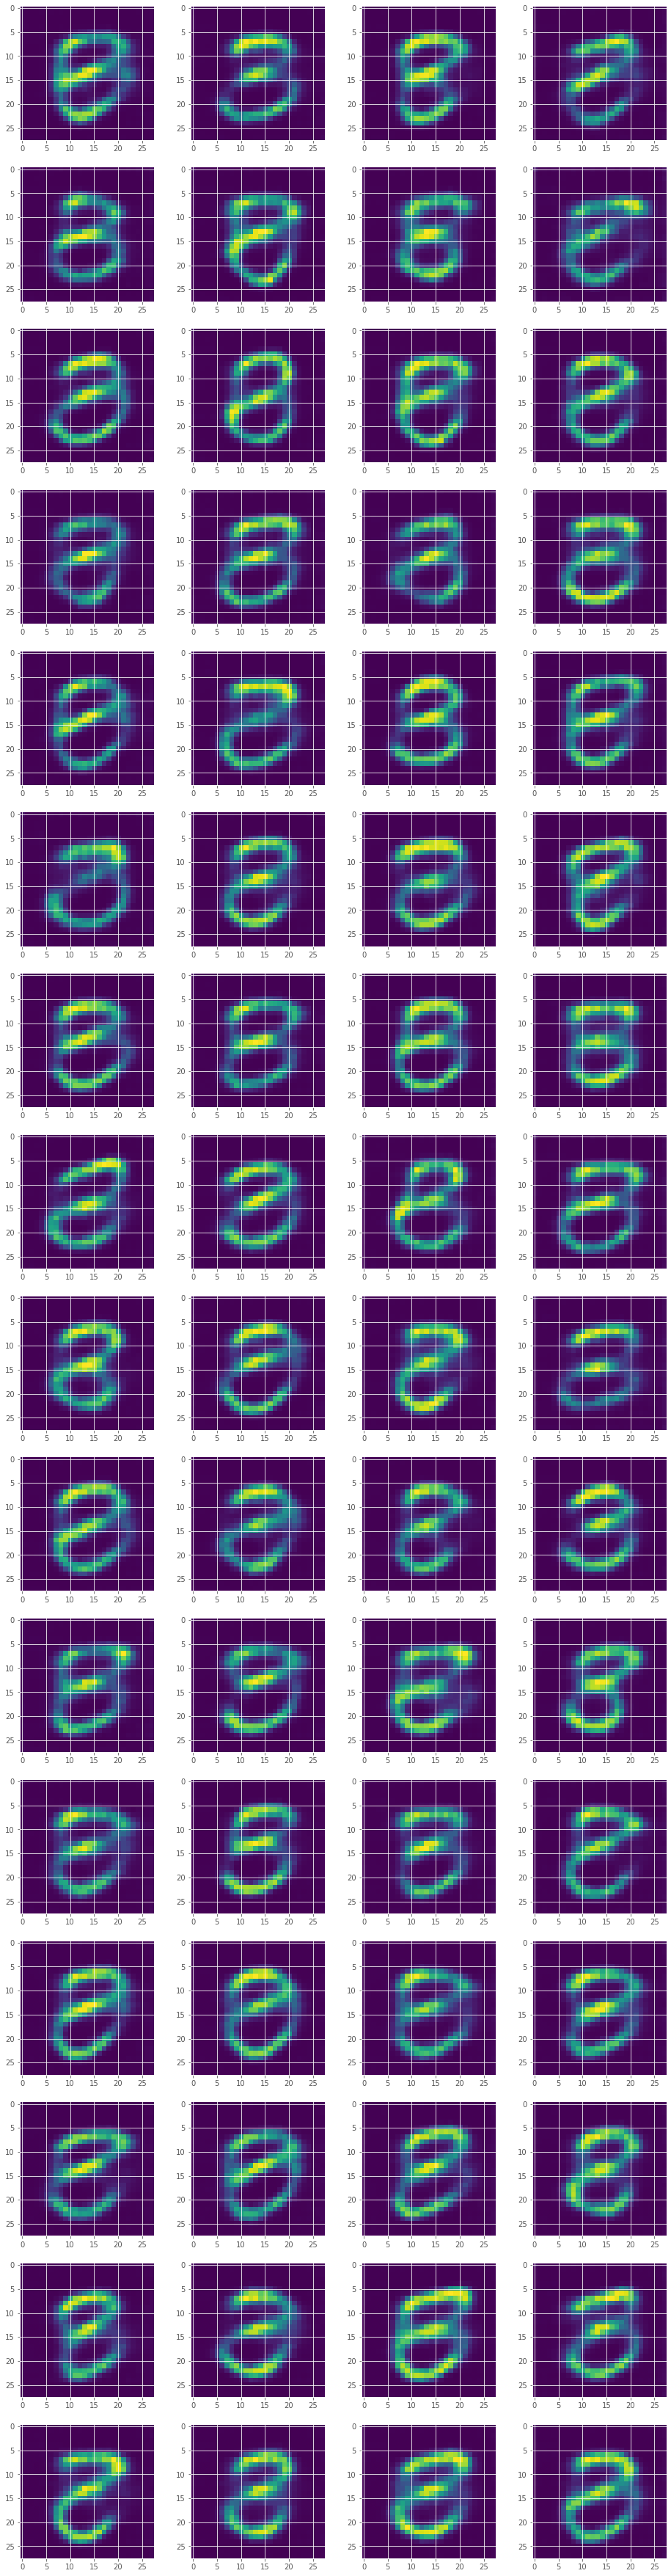

In [6]:
fig=plt.figure(figsize=(16, 64))
columns = 4
rows = 16
for i in range(1, columns*rows + 1):
    img = autoencoder.predict(np.asarray(np.random.random(28*28).reshape([1,28,28,1])))[0,:,:,0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [0]:
#!tf_upgrade_v2 \
#  --intree my_project/ \
#  --outtree my_project_v2/ \
#  --reportfile report.txt

In [0]:
import imageio

In [0]:
dwarves = imageio.imread('dwarves.png')

In [103]:
dwarves.shape

(352, 192, 3)

In [0]:
tiles = np.expand_dims(dwarves, axis=-1)
tiles = tiles.astype("float32") / 255.0
tiles_r = tiles[:,:, 0, :]
tiles_g = tiles[:,:, 1, :]
tiles_b = tiles[:,:, 2, :]

In [0]:
M = 16
N = 16

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)


tiles_r = [tiles_r[x:x+M,y:y+N] for x in range(0,tiles_r.shape[0],M) for y in range(0,tiles_r.shape[1],N)]
tiles_g = [tiles_g[x:x+M,y:y+N] for x in range(0,tiles_g.shape[0],M) for y in range(0,tiles_g.shape[1],N)]
tiles_b = [tiles_b[x:x+M,y:y+N] for x in range(0,tiles_b.shape[0],M) for y in range(0,tiles_b.shape[1],N)]

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)

tiles_r = tiles_r[[np.var(x) != 0 for x in tiles_r]]
tiles_g = tiles_g[[np.var(x) != 0 for x in tiles_g]]
tiles_b = tiles_b[[np.var(x) != 0 for x in tiles_b]]

In [106]:
tiles_r.shape

(227, 16, 16, 1)

([], <a list of 0 Text yticklabel objects>)

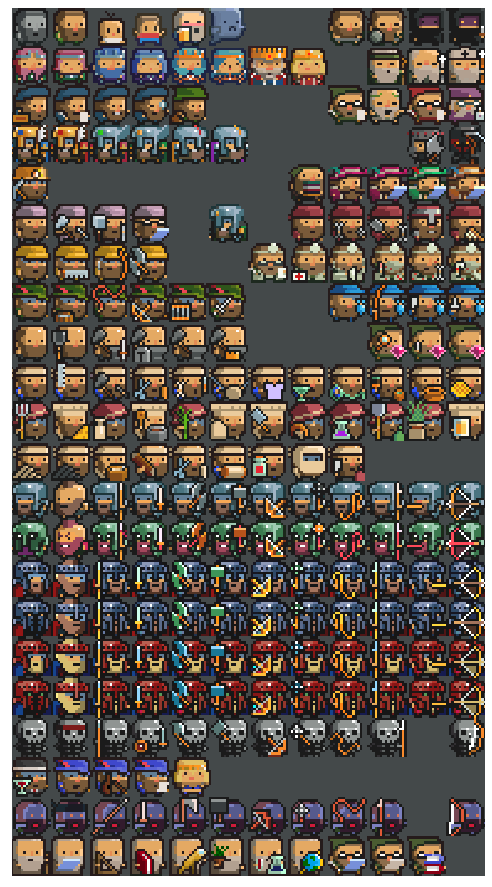

In [107]:
plt.figure(figsize=(16, 16))
plt.imshow(dwarves)
plt.xticks([])
plt.yticks([])

In [0]:
trainX = tiles_r

In [109]:
EPOCHS = 25
BS = 32

# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	epochs=EPOCHS,
	batch_size=BS)

[INFO] building autoencoder...
Train on 227 samples
Epoch 1/25
227/227 [==============================] - 2s 8ms/sample - loss: 0.1027
Epoch 2/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0614
Epoch 3/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0515
Epoch 4/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0461
Epoch 5/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0410
Epoch 6/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0380
Epoch 7/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0349
Epoch 8/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0330
Epoch 9/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0313
Epoch 10/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0296
Epoch 11/25
227/227 [==============================] - 0s 1ms/sample - loss: 0.0281
Epoch 12/25
227/227 [============

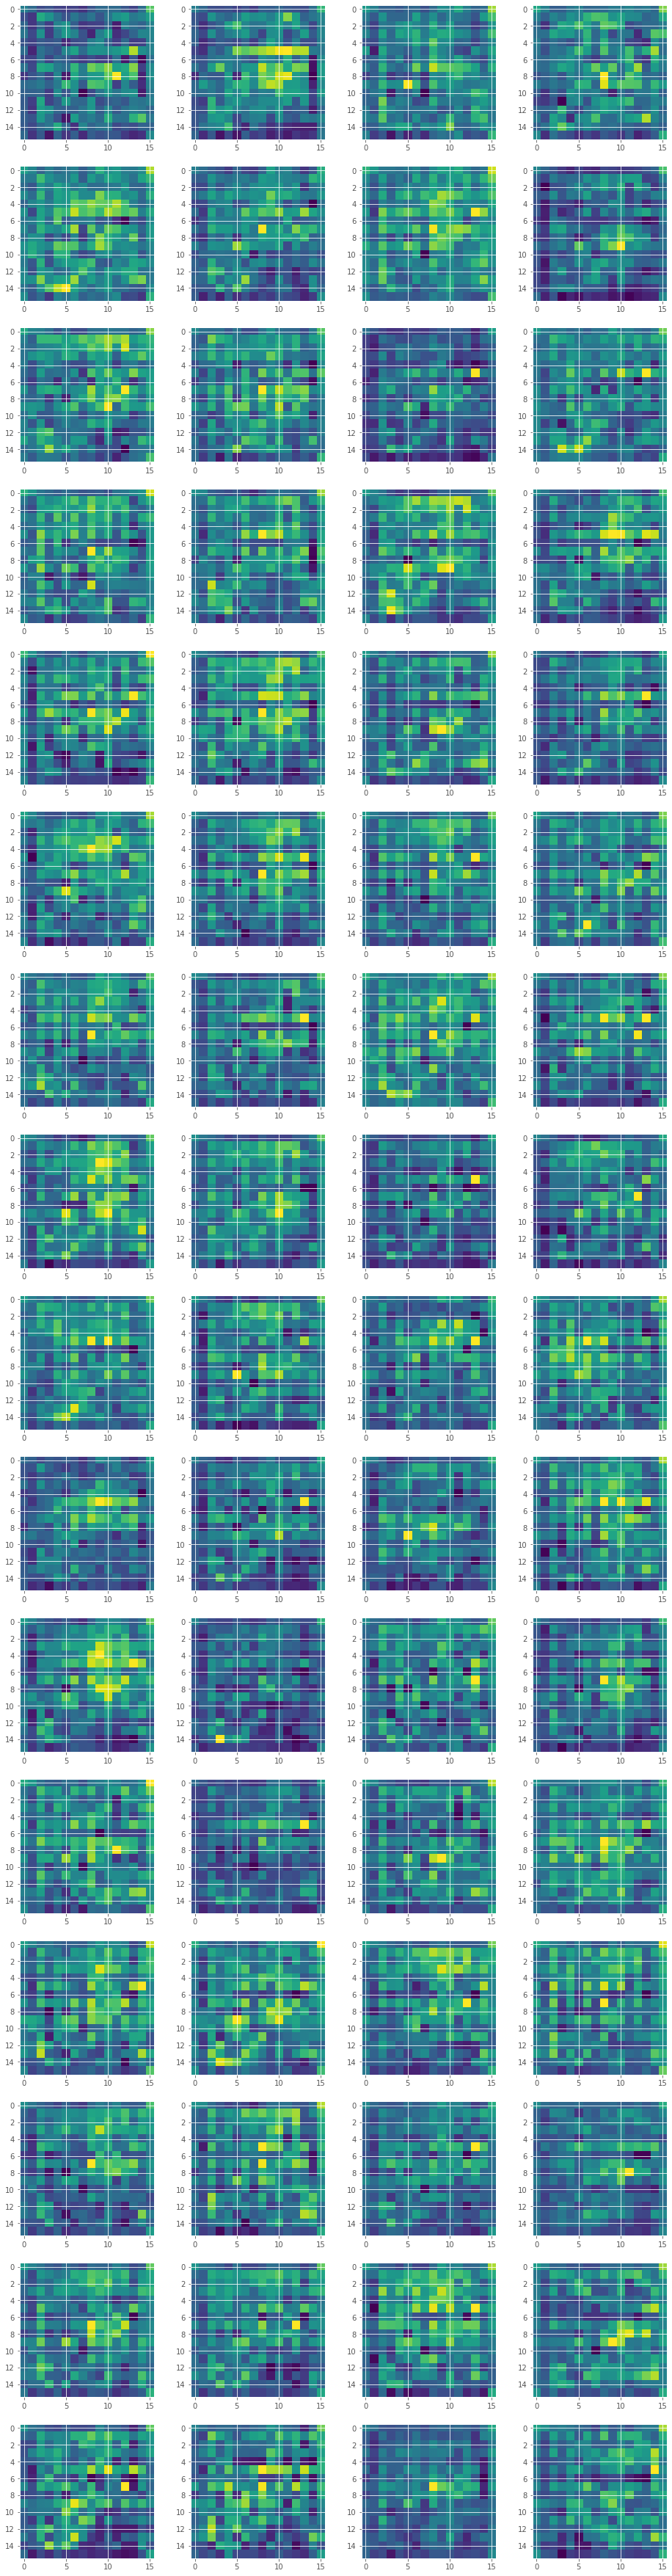

In [110]:
fig=plt.figure(figsize=(16, 64))
columns = 4
rows = 16
for i in range(1, columns*rows + 1):
    img = autoencoder.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [0]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i+lv//3], 16) for i in range(0, lv, lv//3))

In [112]:
hex_to_rgb(rgb_to_hex((255, 255, 195)))

(255, 255, 195)

In [113]:
from ast import literal_eval 
  
hex = rgb_to_hex((255, 255, 195))
print(hex)
literal_eval("0x" + str(hex))

ffffc3


16777155

In [114]:
trainX.shape

(227, 16, 16, 1)

In [115]:
tiles.shape

(352, 192, 3, 1)

In [0]:
trainX_r = tiles_r
trainX_g = tiles_g
trainX_b = tiles_b

In [117]:
EPOCHS = 25
BS = 8



# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_r, decoder_r, autoencoder_r) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_r.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_r.fit(
	trainX_r, trainX_r,
	epochs=EPOCHS,
	batch_size=BS)




# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_g, decoder_g, autoencoder_g) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_g.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_g.fit(
	trainX_g, trainX_g,
	epochs=EPOCHS,
	batch_size=BS)




# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_b, decoder_b, autoencoder_b) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_b.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_b.fit(
	trainX_b, trainX_b,
	epochs=EPOCHS,
	batch_size=BS)




[INFO] building autoencoder...
Train on 227 samples
Epoch 1/25
227/227 [==============================] - 2s 10ms/sample - loss: 0.0768
Epoch 2/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0477
Epoch 3/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0386
Epoch 4/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 5/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0304
Epoch 6/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0273
Epoch 7/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0256
Epoch 8/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0233
Epoch 9/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0222
Epoch 10/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0208
Epoch 11/25
227/227 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 12/25
227/227 [===========

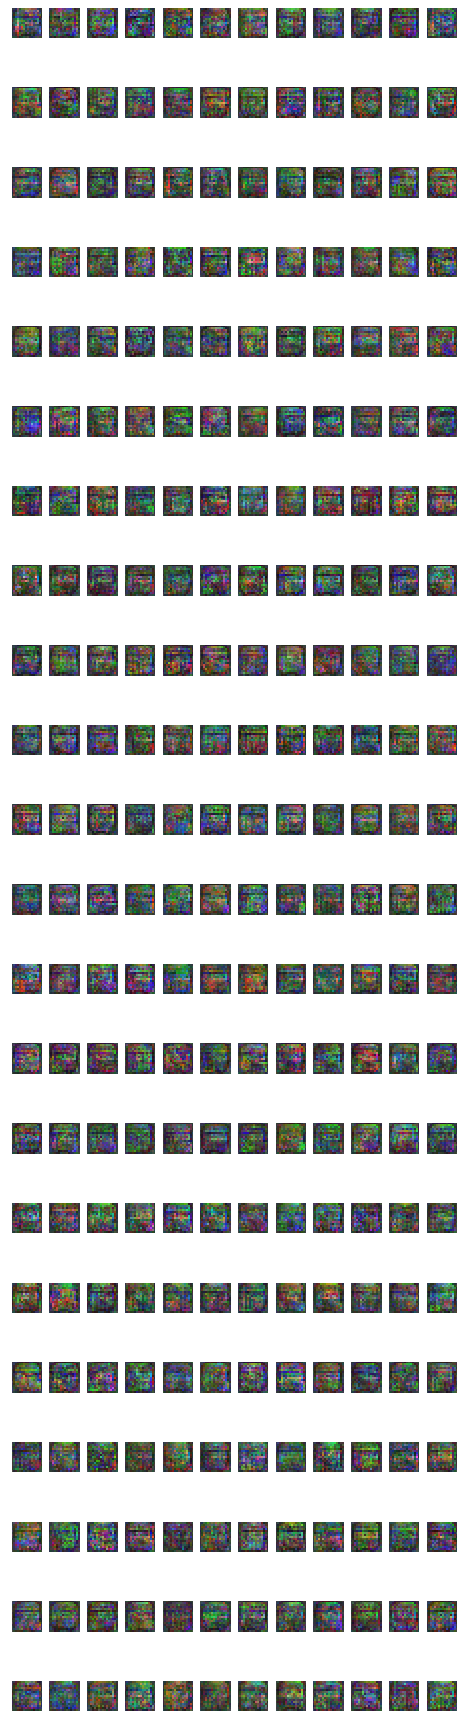

In [118]:
fig=plt.figure(figsize=(8, 32))
columns = 12
rows = 22
for i in range(1, columns*rows + 1):
    img_r = autoencoder_r.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_g = autoencoder_g.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_b = autoencoder_b.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)
plt.show()

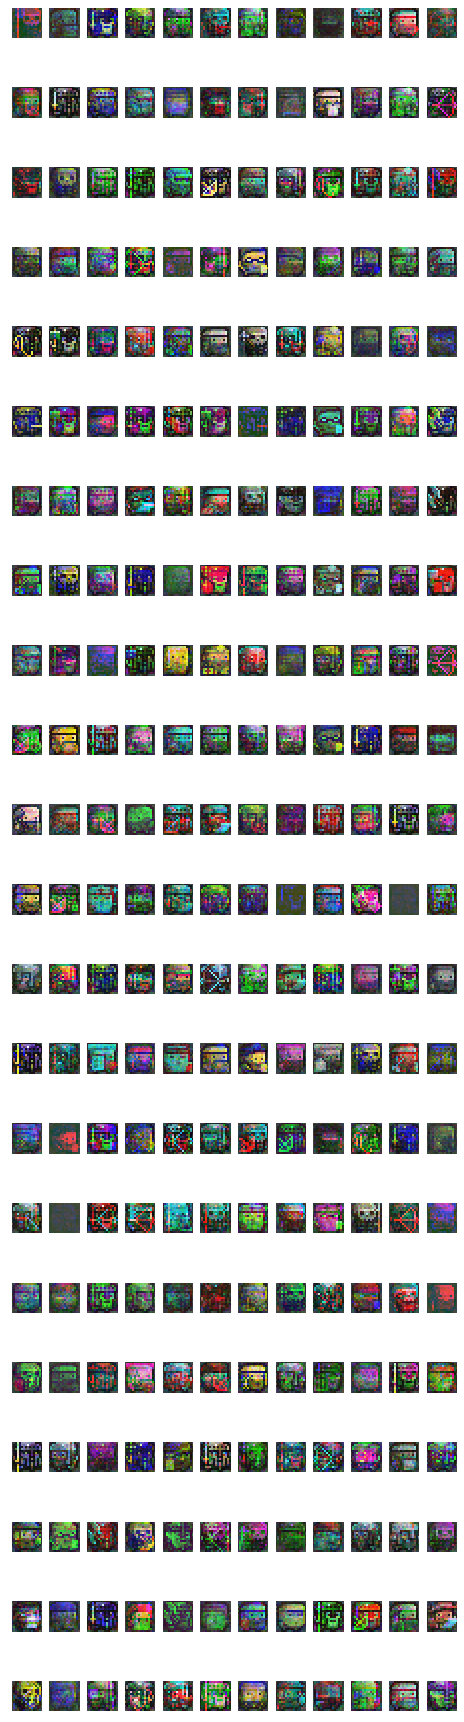

In [120]:
fig = plt.figure(figsize=(8, 32))
columns = 12
rows = 22

for i in range(1, columns*rows + 1):

    r = np.random.randint(0,227)
    g = np.random.randint(0,227)
    b = np.random.randint(0,227)

    x = np.random.randint(0,3)
    y = np.random.randint(0,3)
    z = np.random.randint(0,3)

    d = [np.asarray(trainX_r[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[g-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[b-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[x])[0,:,:,0]
    img_g = autoencoder_g.predict(d[y])[0,:,:,0]
    img_b = autoencoder_b.predict(d[z])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

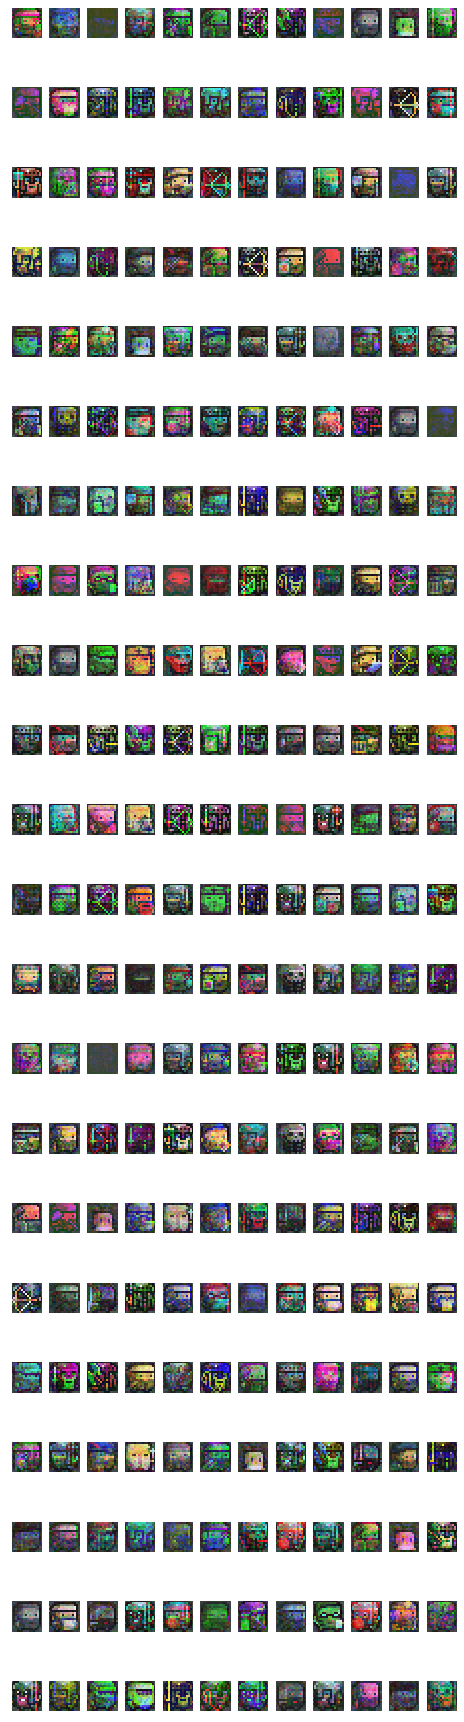

In [121]:
fig = plt.figure(figsize=(8, 32))
columns = 12
rows = 22

for i in range(1, columns*rows + 1):

    r = np.random.randint(0,227)
    #g = np.random.randint(0,227)
    #b = np.random.randint(0,227)

    x = np.random.randint(0,3)
    y = np.random.randint(0,3)
    z = np.random.randint(0,3)

    d = [np.asarray(trainX_r[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[r-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[x])[0,:,:,0]
    img_g = autoencoder_g.predict(d[y])[0,:,:,0]
    img_b = autoencoder_b.predict(d[z])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

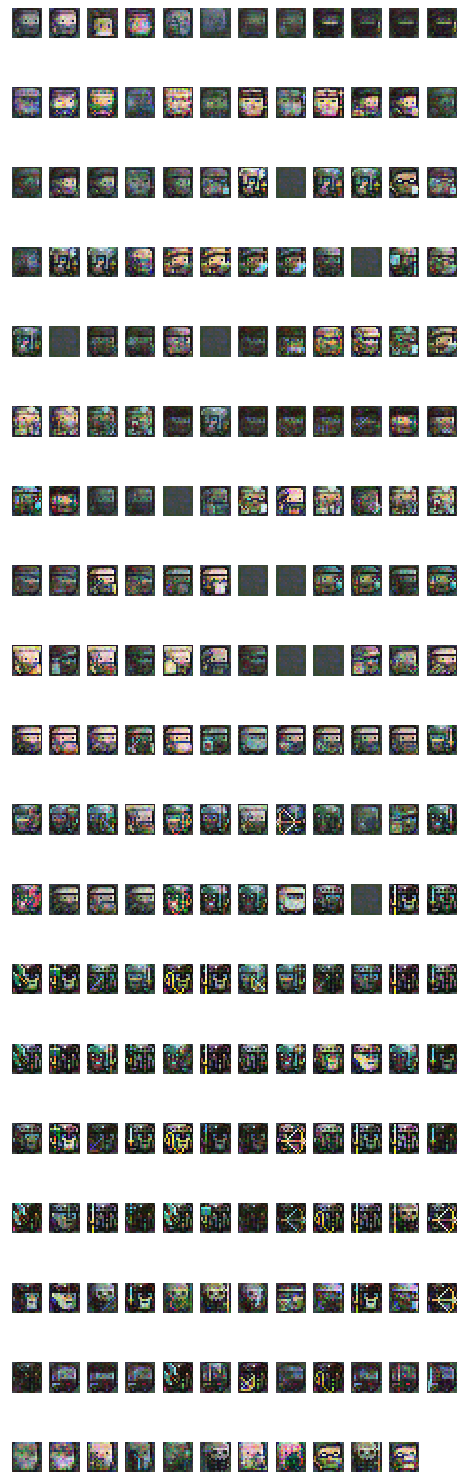

In [123]:
fig = plt.figure(figsize=(8, 32))
columns = 12
rows = 22

for i in range(1, 227 + 1):

    #r = np.random.randint(0,227)
    #g = np.random.randint(0,227)
    #b = np.random.randint(0,227)

    x = np.random.randint(0,3)
    #y = np.random.randint(0,3)
    #z = np.random.randint(0,3)

    d = [np.asarray(trainX_r[i-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[i-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[i-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[x])[0,:,:,0]
    img_g = autoencoder_g.predict(d[x])[0,:,:,0]
    img_b = autoencoder_b.predict(d[x])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

In [0]:
dwarves2 = imageio.imread('sprite.png')

In [0]:
tiles = np.expand_dims(dwarves2, axis=-1)
tiles = tiles.astype("float32") / 255.0
tiles_r = tiles[:,:, 0, :]
tiles_g = tiles[:,:, 1, :]
tiles_b = tiles[:,:, 2, :]

In [0]:
M = 16
N = 16

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)


tiles_r = [tiles_r[x:x+M,y:y+N] for x in range(0,tiles_r.shape[0],M) for y in range(0,tiles_r.shape[1],N)]
tiles_g = [tiles_g[x:x+M,y:y+N] for x in range(0,tiles_g.shape[0],M) for y in range(0,tiles_g.shape[1],N)]
tiles_b = [tiles_b[x:x+M,y:y+N] for x in range(0,tiles_b.shape[0],M) for y in range(0,tiles_b.shape[1],N)]

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)

In [0]:
trainX_r = tiles_r
trainX_g = tiles_g
trainX_b = tiles_b

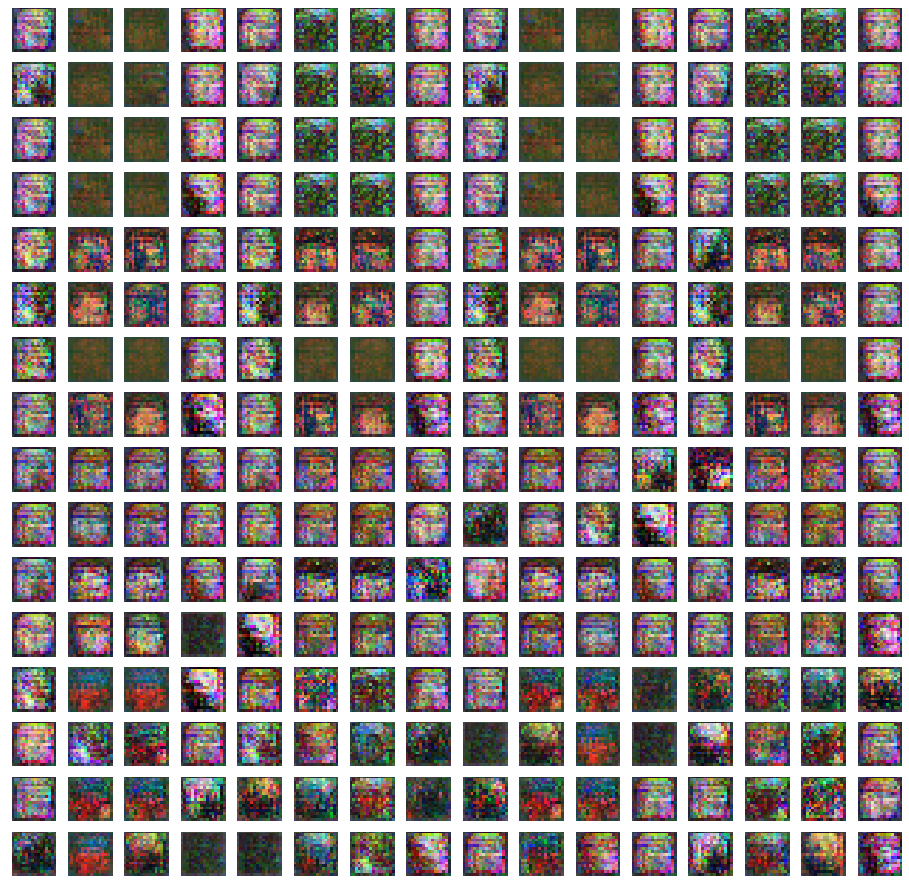

In [128]:
fig = plt.figure(figsize=(16, 16))
columns = 16
rows = 16

for i in range(1, columns*rows + 1):

    d = [np.asarray(trainX_r[i-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[i-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[i-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[0])[0,:,:,0]
    img_g = autoencoder_g.predict(d[1])[0,:,:,0]
    img_b = autoencoder_b.predict(d[2])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

([], <a list of 0 Text yticklabel objects>)

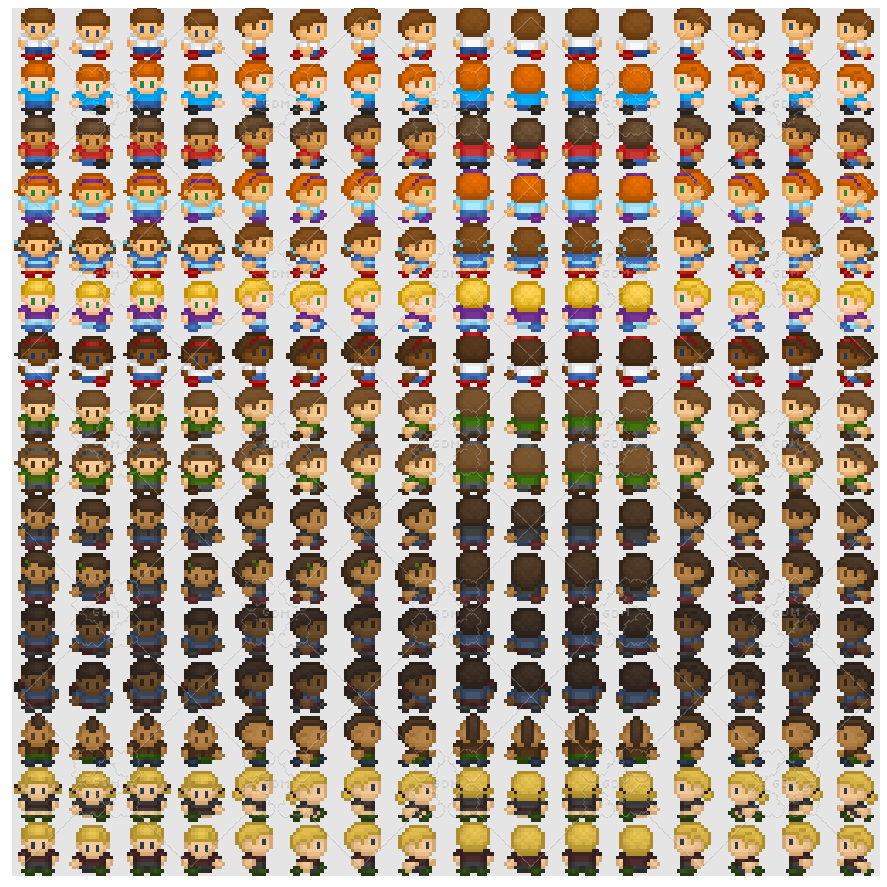

In [129]:
plt.figure(figsize=(16, 16))
plt.imshow(dwarves2)
plt.xticks([])
plt.yticks([])

In [0]:
dwarves = imageio.imread('dwarves.png')

In [173]:
dwarves.shape

(352, 192, 3)

In [0]:
tiles = np.expand_dims(dwarves, axis=-1)
tiles = tiles.astype("float32") / 255.0
tiles_r = tiles[:,:, 0, :]
tiles_g = tiles[:,:, 1, :]
tiles_b = tiles[:,:, 2, :]

In [0]:
M = 16
N = 16

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)


tiles_r = [tiles_r[x:x+M,y:y+N] for x in range(0,tiles_r.shape[0],M) for y in range(0,tiles_r.shape[1],N)]
tiles_g = [tiles_g[x:x+M,y:y+N] for x in range(0,tiles_g.shape[0],M) for y in range(0,tiles_g.shape[1],N)]
tiles_b = [tiles_b[x:x+M,y:y+N] for x in range(0,tiles_b.shape[0],M) for y in range(0,tiles_b.shape[1],N)]

tiles_r = np.asarray(tiles_r)
tiles_g = np.asarray(tiles_g)
tiles_b = np.asarray(tiles_b)

trainX_r = tiles_r[[np.var(x) > 0.01 for x in tiles_r]]
trainX_g = tiles_g[[np.var(x) > 0.01 for x in tiles_r]]
trainX_b = tiles_b[[np.var(x) > 0.01 for x in tiles_r]]


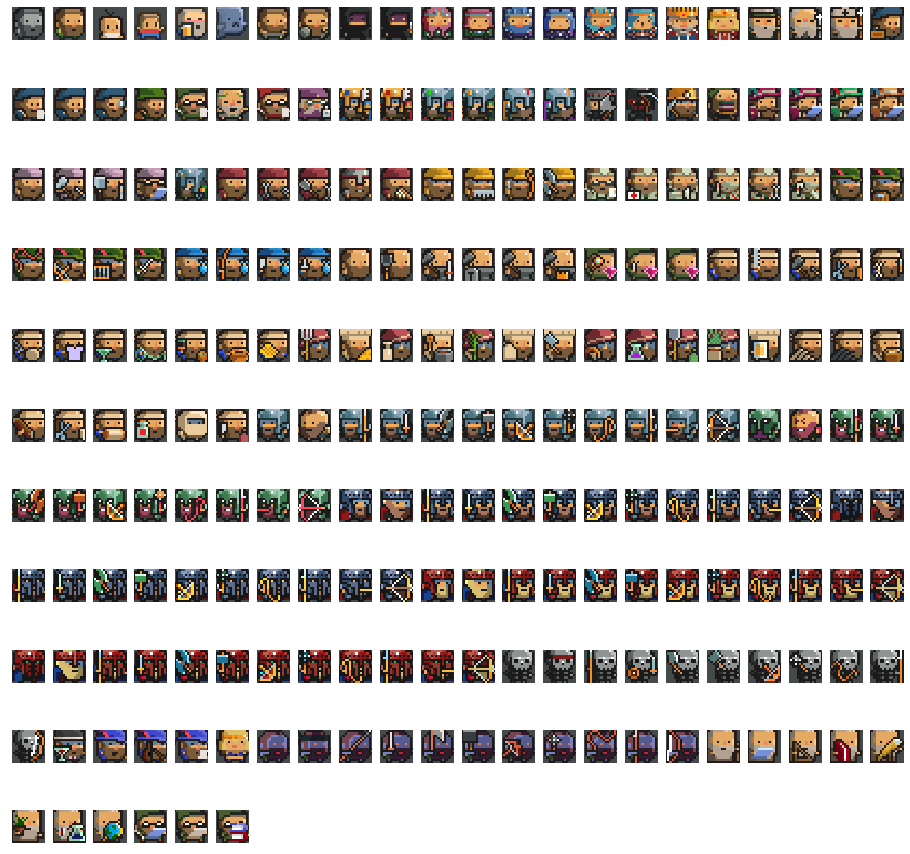

In [176]:
fig = plt.figure(figsize=(16, 16))
columns = 22
rows = 11

for i in range(1, 226 + 1):

    d = [np.asarray(trainX_r[i-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[i-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[i-1,:,:,:]).reshape([1,16,16,1])]

    img_r = d[0][0,:,:,0]
    img_g = d[1][0,:,:,0]
    img_b = d[2][0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

In [177]:
trainX_r.shape

(226, 16, 16, 1)

In [178]:
trainX_g.shape

(226, 16, 16, 1)

In [179]:
trainX_b.shape

(226, 16, 16, 1)

In [180]:
EPOCHS = 25
BS = 8



# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_r, decoder_r, autoencoder_r) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_r.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_r.fit(
	trainX_r, trainX_r,
	epochs=EPOCHS,
	batch_size=BS)




# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_g, decoder_g, autoencoder_g) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_g.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_g.fit(
	trainX_g, trainX_g,
	epochs=EPOCHS,
	batch_size=BS)




# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder_b, decoder_b, autoencoder_b) = ConvAutoencoder.build(16, 16, 1)
opt = Adam(lr=1e-3)
autoencoder_b.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder_b.fit(
	trainX_b, trainX_b,
	epochs=EPOCHS,
	batch_size=BS)



[INFO] building autoencoder...
Train on 226 samples
Epoch 1/25
226/226 [==============================] - 3s 13ms/sample - loss: 0.0783
Epoch 2/25
226/226 [==============================] - 0s 2ms/sample - loss: 0.0474
Epoch 3/25
226/226 [==============================] - 0s 2ms/sample - loss: 0.0398
Epoch 4/25
226/226 [==============================] - 0s 2ms/sample - loss: 0.0347
Epoch 5/25
226/226 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 6/25
226/226 [==============================] - 0s 2ms/sample - loss: 0.0278
Epoch 7/25
226/226 [==============================] - 0s 2ms/sample - loss: 0.0254
Epoch 8/25
226/226 [==============================] - 0s 2ms/sample - loss: 0.0237
Epoch 9/25
226/226 [==============================] - 0s 2ms/sample - loss: 0.0221
Epoch 10/25
226/226 [==============================] - 0s 2ms/sample - loss: 0.0205
Epoch 11/25
226/226 [==============================] - 0s 2ms/sample - loss: 0.0195
Epoch 12/25
226/226 [===========

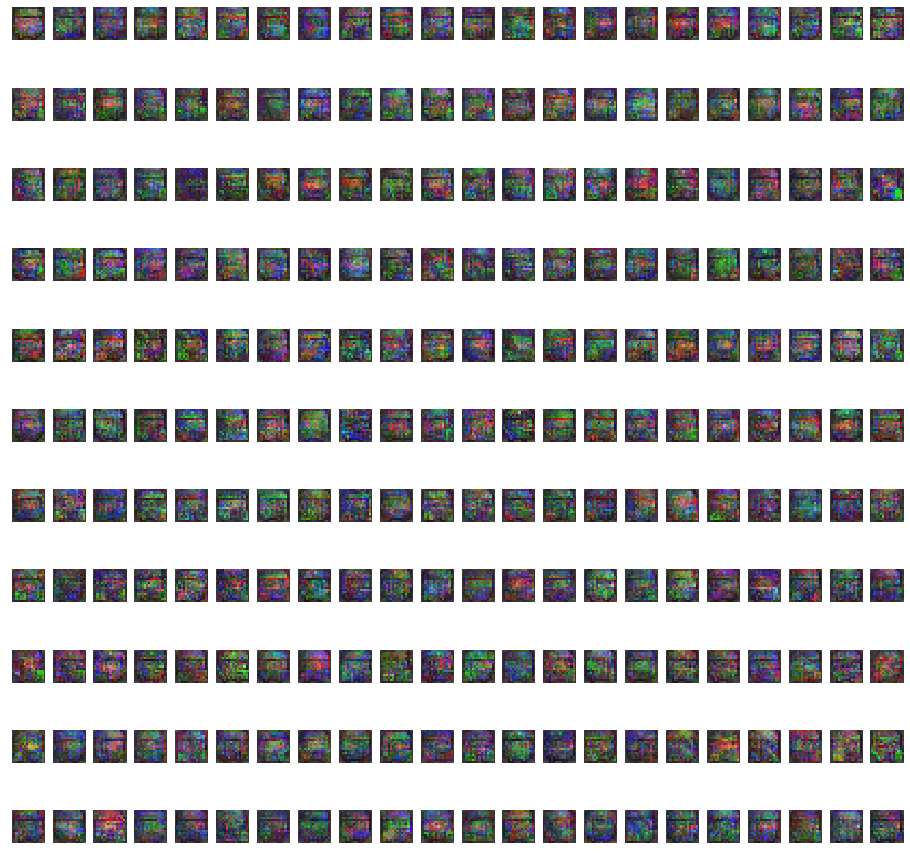

In [183]:
fig=plt.figure(figsize=(16, 16))
columns = 22
rows = 11
for i in range(1, columns*rows + 1):
    img_r = autoencoder_r.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_g = autoencoder_g.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_b = autoencoder_b.predict(np.asarray(np.random.random(16*16).reshape([1,16,16,1])))[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)
plt.show()

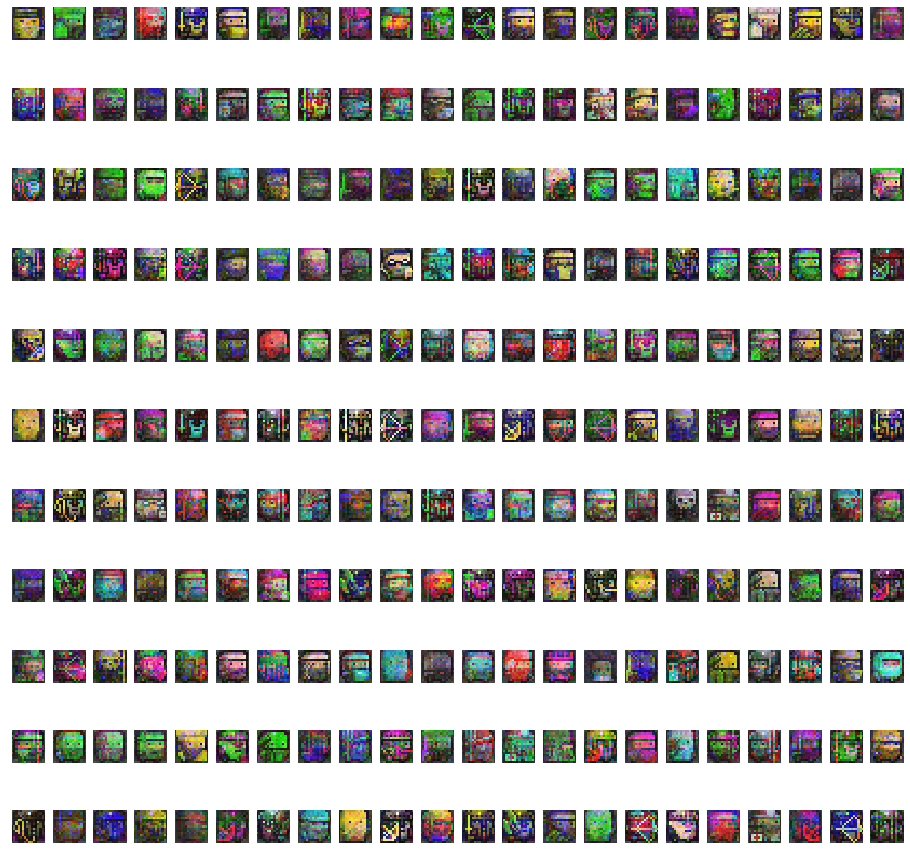

In [184]:
fig = plt.figure(figsize=(16, 16))
columns = 22
rows = 11

for i in range(1, columns*rows + 1):

    r = np.random.randint(0,227)
    g = np.random.randint(0,227)
    b = np.random.randint(0,227)

    x = np.random.randint(0,3)
    y = np.random.randint(0,3)
    z = np.random.randint(0,3)

    d = [np.asarray(trainX_r[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[g-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[b-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[x])[0,:,:,0]
    img_g = autoencoder_g.predict(d[y])[0,:,:,0]
    img_b = autoencoder_b.predict(d[z])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

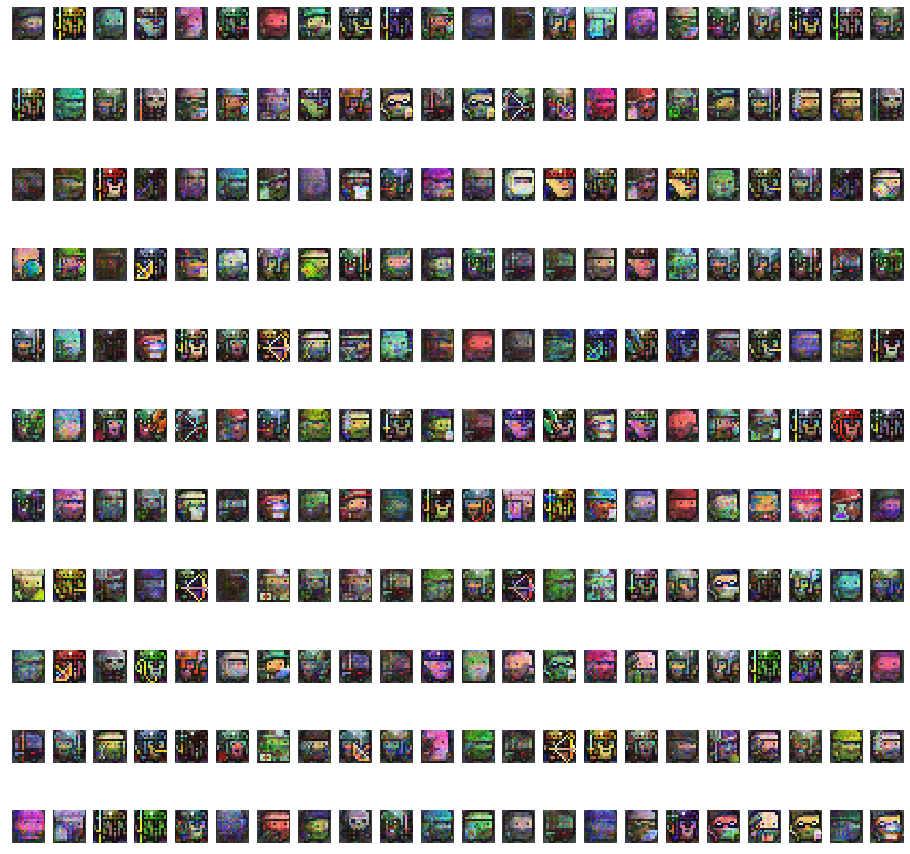

In [185]:
fig = plt.figure(figsize=(16, 16))
columns = 22
rows = 11

for i in range(1, columns*rows + 1):

    r = np.random.randint(0,227)
    #g = np.random.randint(0,227)
    #b = np.random.randint(0,227)

    x = np.random.randint(0,3)
    y = np.random.randint(0,3)
    z = np.random.randint(0,3)

    d = [np.asarray(trainX_r[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[r-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[x])[0,:,:,0]
    img_g = autoencoder_g.predict(d[y])[0,:,:,0]
    img_b = autoencoder_b.predict(d[z])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()

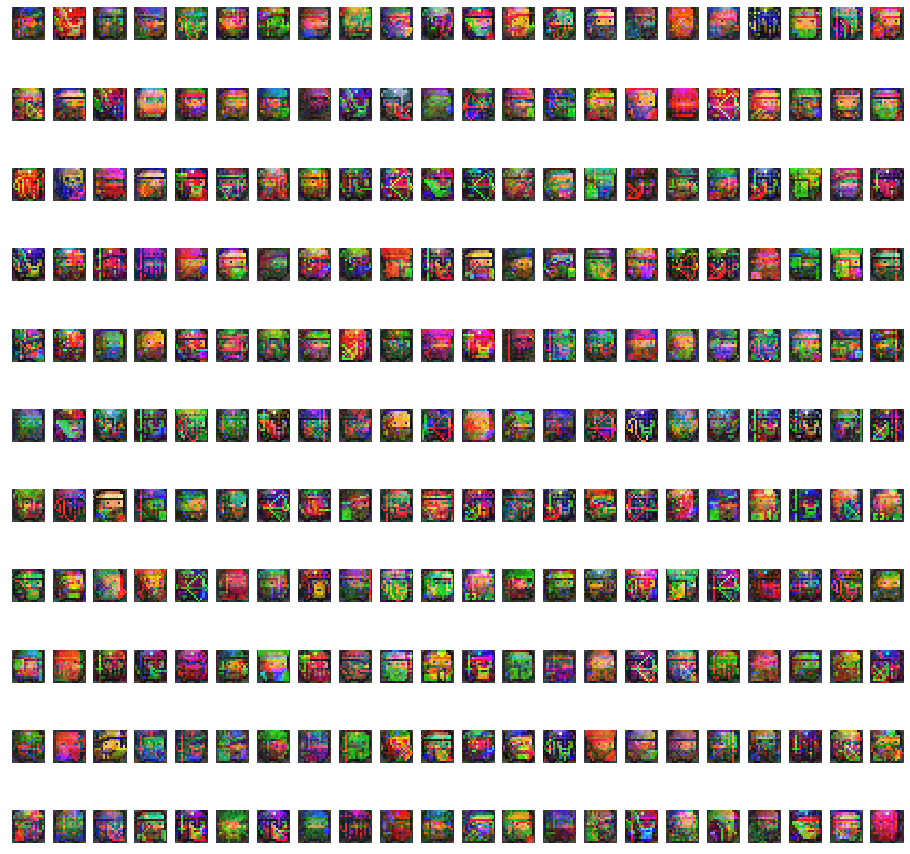

In [187]:
fig = plt.figure(figsize=(16, 16))
columns = 22
rows = 11

for i in range(1, columns*rows + 1):

    r = np.random.randint(0,227)
    g = np.random.randint(0,227)
    b = np.random.randint(0,227)

    #x = np.random.randint(0,3)
    #y = np.random.randint(0,3)
    #z = np.random.randint(0,3)

    d = [np.asarray(trainX_r[r-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_g[g-1,:,:,:]).reshape([1,16,16,1]),
         np.asarray(trainX_b[b-1,:,:,:]).reshape([1,16,16,1])]

    img_r = autoencoder_r.predict(d[0])[0,:,:,0]
    img_g = autoencoder_g.predict(d[1])[0,:,:,0]
    img_b = autoencoder_b.predict(d[2])[0,:,:,0]
    img_rgb = np.dstack((img_r,img_g,img_b))
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_rgb)

plt.show()